In [6]:
species_to_model = {
    "Cassava": "cassava_best.pth",
    "Rice": "rice_leaf_best.pth",

    # All other species → PlantVillage disease classifier
    "Apple": "plant_village_best.pth",
    "Blueberry": "plant_village_best.pth",
    "Cherry_(including_sour)": "plant_village_best.pth",
    "Corn_(maize)": "plant_village_best.pth",
    "Grape": "plant_village_best.pth",
    "Orange": "plant_village_best.pth",
    "Peach": "plant_village_best.pth",
    "Pepper__bell": "plant_village_best.pth",
    "Potato": "plant_village_best.pth",
    "Raspberry": "plant_village_best.pth",
    "Soybean": "plant_village_best.pth",
    "Squash": "plant_village_best.pth",
    "Strawberry": "plant_village_best.pth",
    "Tomato": "plant_village_best.pth",
}


In [7]:
import torch
import cv2
import numpy as np
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# 1. Load YOLO detector
yolo = YOLO("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/models/yolo_plantdoc_detect.pt")

# 2. ViT preprocessing
vit_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


Using device: cpu


In [8]:
def load_vit_model(path, num_classes=None):
    from torchvision import models
    import torch.nn as nn

    model = models.vit_b_16(weights=None)
    if num_classes is not None:
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

    state = torch.load(path, map_location=DEVICE)
    model.load_state_dict(state)
    model.to(DEVICE)
    model.eval()
    return model


def crop_with_bbox(img, box):
    x1, y1, x2, y2 = map(int, box)
    return img[y1:y2, x1:x2]


def vit_predict(img, model, class_names):
    pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    tensor = vit_tfms(pil).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(tensor)
        pred_idx = logits.argmax(1).item()

    return class_names[pred_idx]


In [15]:
import json
import os

# Load class lists from your training notebooks
species_classes = sorted(os.listdir("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/data/processed/Species_split/train"))
pv_classes = sorted(os.listdir("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/data/processed/PlantVillage/train"))
cassava_classes = sorted(os.listdir("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/data/processed/Cassava/train"))
rice_classes = sorted(os.listdir("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/data/processed/Rice/train"))

species_model = load_vit_model("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/models/species_classifier_vit.pth", num_classes=len(species_classes))
pv_model = load_vit_model("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/models/plant_village_best.pth", num_classes=len(pv_classes))
cassava_model = load_vit_model("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/models/cassava_best.pth", num_classes=len(cassava_classes))
rice_model = load_vit_model("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/models/rice_leaf_best.pth", num_classes=len(rice_classes))


In [25]:
def diagnose_image(image_path):
    img = cv2.imread(image_path)

    # -----------------------------
    # 1. YOLO DETECTION
    # -----------------------------
    results = yolo(img)[0]

    # CASE A — YOLO FOUND A LEAF
    if len(results.boxes) > 0:
        box = results.boxes.xyxy[0].cpu().numpy()
        conf = results.boxes.conf[0].item()

        # Crop leaf
        leaf = crop_with_bbox(img, box)

        # Species prediction on cropped leaf
        species = vit_predict(leaf, species_model, species_classes)

        # Select correct disease model
        if species == "Cassava":
            disease = vit_predict(leaf, cassava_model, cassava_classes)
        elif species == "Rice":
            disease = vit_predict(img, rice_model, rice_classes)  # rice = full image
        else:
            disease = vit_predict(leaf, pv_model, pv_classes)

        return species, disease, conf

    # ---------------------------------------------------
    # CASE B — YOLO FAILED → LIKELY A RICE IMAGE OR THIN LEAF
    # ---------------------------------------------------
    fallback_img = img.copy()

    # Predict species on full image
    species = vit_predict(fallback_img, species_model, species_classes)

    # Species routing
    if species == "Cassava":
        disease = vit_predict(fallback_img, cassava_model, cassava_classes)
    elif species == "Rice":
        disease = vit_predict(fallback_img, rice_model, rice_classes)
    else:
        disease = vit_predict(fallback_img, pv_model, pv_classes)

    return species, disease, None


Test model

In [27]:
species, disease, conf = diagnose_image("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/tests/test_images/cassava_Healthy_1272381477.jpg")

print("Species:", species)
print("Disease:", disease)
print("YOLO Conf:", conf)


0: 480x640 10 leafs, 321.0ms
Speed: 5.7ms preprocess, 321.0ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)
Species: Cassava
Disease: Cassava Bacterial Blight (CBB)
YOLO Conf: 0.6612441539764404


In [28]:
species, disease, conf = diagnose_image("C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/tests/test_images/riceleaf_leaf_scald_leaf_scald (157).jpg")

print("Species:", species)
print("Disease:", disease)
print("YOLO Conf:", conf)


0: 640x640 (no detections), 336.7ms
Speed: 10.2ms preprocess, 336.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Species: Rice
Disease: leaf_scald
YOLO Conf: None


In [ ]:
import os
import pandas as pd
from tqdm import tqdm

TEST_DIR = "C:/Users/User/Desktop/Data Science/Projects/crop-disease-detection/tests/test_images"

results = []

def parse_ground_truth(filename):
    name = os.path.basename(filename)

    # PlantVillage: plantVillage_Tomato___Late_blight_....
    if name.startswith("plantVillage"):
        # remove extension
        base = os.path.splitext(name)[0]
        # keep everything after 'plantVillage_'
        rest = base.split("plantVillage_")[1]
        # rest is e.g. 'Tomato___Late_blight_....'
        # we want the exact class folder name 'Tomato___Late_blight'
        parts = rest.split("__")
        species = parts[0]          # 'Tomato'
        disease_full = "__".join(parts[:2])  # 'Tomato___Late_blight'
        return species, disease_full

    # RiceLeaf: riceleaf_leaf_blast_leaf_blast (243).jpg etc.
    elif name.startswith("riceleaf"):
        base = os.path.splitext(name)[0]
        # Example: 'riceleaf_leaf_blast_leaf_blast (243)'
        if "healthy" in base:
            species = "Rice"
            disease = [c for c in rice_classes if "healthy" in c.lower()][0]
            return species, disease

        # crude: find a rice_classes entry that appears in the filename (case insensitive)
        species = "Rice"
        lc = base.lower()
        match = None
        for cls in rice_classes:
            if cls.lower().replace(" ", "_") in lc or cls.lower().replace(" ", "") in lc:
                match = cls
                break
        if match is None:
            match = "Unknown"
        return species, match

    # Cassava: whatever pattern you used; adjust as needed
    elif name.lower().startswith("cassava"):
        base = os.path.splitext(name)[0]
        # try to match any cassava class name inside filename
        lc = base.lower()
        match = None
        for cls in cassava_classes:
            if cls.lower().replace(" ", "_") in lc or cls.lower().replace(" ", "") in lc:
                match = cls
                break
        species = "Cassava"
        if match is None:
            match = "Unknown"
        return species, match

    else:
        return "Unknown", "Unknown"


  0%|          | 0/104 [00:00<?, ?it/s]

0: 480x640 9 leafs, 391.6ms
Speed: 7.9ms preprocess, 391.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


  1%|          | 1/104 [00:01<02:26,  1.42s/it]


0: 480x640 9 leafs, 327.6ms
Speed: 4.1ms preprocess, 327.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


  2%|▏         | 2/104 [00:02<02:11,  1.29s/it]


0: 480x640 5 leafs, 308.5ms
Speed: 3.8ms preprocess, 308.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


  3%|▎         | 3/104 [00:03<02:00,  1.19s/it]


0: 480x640 4 leafs, 233.3ms
Speed: 3.8ms preprocess, 233.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  4%|▍         | 4/104 [00:04<01:49,  1.09s/it]


0: 480x640 10 leafs, 218.2ms
Speed: 3.8ms preprocess, 218.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


  5%|▍         | 5/104 [00:05<01:45,  1.06s/it]


0: 480x640 8 leafs, 371.5ms
Speed: 3.7ms preprocess, 371.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


  6%|▌         | 6/104 [00:06<01:44,  1.07s/it]


0: 480x640 20 leafs, 211.9ms
Speed: 3.6ms preprocess, 211.9ms inference, 18.2ms postprocess per image at shape (1, 3, 480, 640)


  7%|▋         | 7/104 [00:07<01:39,  1.03s/it]


0: 480x640 3 leafs, 297.0ms
Speed: 4.0ms preprocess, 297.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


  8%|▊         | 8/104 [00:08<01:38,  1.02s/it]


0: 480x640 10 leafs, 232.5ms
Speed: 3.2ms preprocess, 232.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|▊         | 9/104 [00:09<01:35,  1.01s/it]


0: 480x640 10 leafs, 216.0ms
Speed: 4.0ms preprocess, 216.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 10%|▉         | 10/104 [00:10<01:33,  1.00it/s]


0: 416x640 1 leaf, 266.1ms
Speed: 3.6ms preprocess, 266.1ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 11%|█         | 11/104 [00:11<01:37,  1.05s/it]


0: 640x448 1 leaf, 305.5ms
Speed: 3.1ms preprocess, 305.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 12%|█▏        | 12/104 [00:12<01:39,  1.08s/it]


0: 448x640 1 leaf, 308.7ms
Speed: 2.9ms preprocess, 308.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 12%|█▎        | 13/104 [00:14<01:38,  1.08s/it]


0: 480x640 1 leaf, 284.8ms
Speed: 3.1ms preprocess, 284.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 13%|█▎        | 14/104 [00:15<01:44,  1.16s/it]


0: 480x640 2 leafs, 319.2ms
Speed: 4.5ms preprocess, 319.2ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 640)


 14%|█▍        | 15/104 [00:16<01:43,  1.17s/it]


0: 480x640 4 leafs, 222.1ms
Speed: 3.3ms preprocess, 222.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 15%|█▌        | 16/104 [00:17<01:37,  1.11s/it]


0: 640x640 3 leafs, 323.7ms
Speed: 10.1ms preprocess, 323.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 17/104 [00:18<01:36,  1.10s/it]


0: 640x640 2 leafs, 345.4ms
Speed: 6.7ms preprocess, 345.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 18/104 [00:19<01:35,  1.11s/it]


0: 640x640 1 leaf, 315.6ms
Speed: 7.2ms preprocess, 315.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 19/104 [00:20<01:33,  1.11s/it]


0: 640x640 1 leaf, 363.2ms
Speed: 6.4ms preprocess, 363.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 20/104 [00:21<01:27,  1.04s/it]


0: 640x640 1 leaf, 365.4ms
Speed: 6.3ms preprocess, 365.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 21/104 [00:22<01:27,  1.05s/it]


0: 640x640 2 leafs, 292.7ms
Speed: 7.4ms preprocess, 292.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 22/104 [00:23<01:24,  1.03s/it]


0: 640x640 1 leaf, 330.5ms
Speed: 5.8ms preprocess, 330.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 23/104 [00:24<01:26,  1.07s/it]


0: 640x640 1 leaf, 426.4ms
Speed: 11.9ms preprocess, 426.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 24/104 [00:26<01:33,  1.17s/it]


0: 640x640 2 leafs, 505.2ms
Speed: 8.4ms preprocess, 505.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 25/104 [00:27<01:40,  1.27s/it]


0: 640x640 1 leaf, 420.8ms
Speed: 7.5ms preprocess, 420.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 26/104 [00:29<01:42,  1.31s/it]


0: 640x640 1 leaf, 360.9ms
Speed: 8.2ms preprocess, 360.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 27/104 [00:30<01:41,  1.31s/it]


0: 640x640 1 leaf, 405.3ms
Speed: 8.1ms preprocess, 405.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 28/104 [00:31<01:36,  1.27s/it]


0: 640x640 2 leafs, 414.6ms
Speed: 8.3ms preprocess, 414.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 29/104 [00:33<01:38,  1.31s/it]


0: 640x640 2 leafs, 345.8ms
Speed: 7.9ms preprocess, 345.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 30/104 [00:34<01:37,  1.31s/it]


0: 640x640 1 leaf, 457.3ms
Speed: 8.1ms preprocess, 457.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 31/104 [00:35<01:39,  1.36s/it]


0: 640x640 2 leafs, 403.8ms
Speed: 10.2ms preprocess, 403.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 32/104 [00:37<01:38,  1.37s/it]


0: 640x640 1 leaf, 366.1ms
Speed: 9.6ms preprocess, 366.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 33/104 [00:38<01:36,  1.35s/it]


0: 640x640 1 leaf, 384.6ms
Speed: 10.4ms preprocess, 384.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 34/104 [00:39<01:34,  1.35s/it]


0: 640x640 3 leafs, 357.4ms
Speed: 7.7ms preprocess, 357.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 35/104 [00:41<01:32,  1.34s/it]


0: 640x640 1 leaf, 353.4ms
Speed: 8.4ms preprocess, 353.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 36/104 [00:42<01:30,  1.33s/it]


0: 640x640 2 leafs, 397.5ms
Speed: 6.9ms preprocess, 397.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 37/104 [00:43<01:23,  1.25s/it]


0: 640x640 1 leaf, 343.5ms
Speed: 9.6ms preprocess, 343.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 38/104 [00:44<01:18,  1.20s/it]


0: 640x640 6 leafs, 332.1ms
Speed: 7.9ms preprocess, 332.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 39/104 [00:45<01:14,  1.14s/it]


0: 640x640 3 leafs, 425.5ms
Speed: 8.1ms preprocess, 425.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 40/104 [00:46<01:14,  1.17s/it]


0: 640x640 2 leafs, 379.1ms
Speed: 7.9ms preprocess, 379.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 41/104 [00:48<01:17,  1.22s/it]


0: 640x640 3 leafs, 421.2ms
Speed: 9.5ms preprocess, 421.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 42/104 [00:49<01:19,  1.27s/it]


0: 640x640 1 leaf, 403.8ms
Speed: 8.5ms preprocess, 403.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 43/104 [00:51<01:19,  1.30s/it]


0: 640x640 2 leafs, 392.2ms
Speed: 7.7ms preprocess, 392.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 44/104 [00:52<01:16,  1.28s/it]


0: 640x640 1 leaf, 419.1ms
Speed: 8.5ms preprocess, 419.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 45/104 [00:53<01:18,  1.33s/it]


0: 640x640 1 leaf, 380.6ms
Speed: 7.3ms preprocess, 380.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 46/104 [00:55<01:18,  1.35s/it]


0: 640x640 1 leaf, 534.9ms
Speed: 7.9ms preprocess, 534.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 47/104 [00:56<01:18,  1.38s/it]


0: 640x640 1 leaf, 405.3ms
Speed: 7.6ms preprocess, 405.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 48/104 [00:58<01:17,  1.39s/it]


0: 640x640 1 leaf, 421.0ms
Speed: 7.9ms preprocess, 421.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 49/104 [00:59<01:17,  1.40s/it]


0: 640x640 1 leaf, 367.2ms
Speed: 8.7ms preprocess, 367.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 50/104 [01:00<01:14,  1.38s/it]


0: 640x640 2 leafs, 391.7ms
Speed: 7.0ms preprocess, 391.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 51/104 [01:02<01:13,  1.39s/it]


0: 640x640 2 leafs, 348.1ms
Speed: 10.0ms preprocess, 348.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 52/104 [01:03<01:09,  1.33s/it]


0: 640x640 1 leaf, 317.3ms
Speed: 7.5ms preprocess, 317.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 53/104 [01:04<01:06,  1.31s/it]


0: 640x640 1 leaf, 389.3ms
Speed: 12.0ms preprocess, 389.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 54/104 [01:06<01:06,  1.32s/it]


0: 640x640 1 leaf, 456.0ms
Speed: 7.8ms preprocess, 456.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 55/104 [01:07<01:06,  1.35s/it]


0: 640x640 1 leaf, 339.8ms
Speed: 7.6ms preprocess, 339.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 56/104 [01:08<01:03,  1.33s/it]


0: 640x640 1 leaf, 347.0ms
Speed: 7.8ms preprocess, 347.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 57/104 [01:10<01:02,  1.32s/it]


0: 640x640 1 leaf, 338.6ms
Speed: 8.9ms preprocess, 338.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 58/104 [01:11<00:57,  1.25s/it]


0: 640x640 1 leaf, 364.5ms
Speed: 7.9ms preprocess, 364.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 59/104 [01:12<00:57,  1.27s/it]


0: 640x640 1 leaf, 332.9ms
Speed: 9.5ms preprocess, 332.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 60/104 [01:13<00:55,  1.27s/it]


0: 640x640 2 leafs, 313.0ms
Speed: 7.5ms preprocess, 313.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 61/104 [01:14<00:55,  1.29s/it]


0: 640x640 1 leaf, 345.8ms
Speed: 7.5ms preprocess, 345.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 62/104 [01:16<00:54,  1.31s/it]


0: 640x640 1 leaf, 334.3ms
Speed: 7.5ms preprocess, 334.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 63/104 [01:17<00:53,  1.30s/it]


0: 640x640 3 leafs, 356.8ms
Speed: 8.3ms preprocess, 356.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 64/104 [01:18<00:51,  1.30s/it]


0: 640x640 1 leaf, 339.7ms
Speed: 7.1ms preprocess, 339.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▎   | 65/104 [01:20<00:50,  1.29s/it]


0: 640x640 1 leaf, 336.6ms
Speed: 9.9ms preprocess, 336.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 66/104 [01:21<00:48,  1.28s/it]


0: 640x640 2 leafs, 311.9ms
Speed: 7.3ms preprocess, 311.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 67/104 [01:22<00:47,  1.27s/it]


0: 640x640 3 leafs, 330.2ms
Speed: 7.2ms preprocess, 330.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 68/104 [01:24<00:46,  1.29s/it]


0: 640x640 1 leaf, 610.4ms
Speed: 9.7ms preprocess, 610.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 69/104 [01:25<00:49,  1.41s/it]


0: 640x640 1 leaf, 573.9ms
Speed: 10.1ms preprocess, 573.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 70/104 [01:27<00:49,  1.47s/it]


0: 640x640 1 leaf, 384.7ms
Speed: 7.1ms preprocess, 384.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 71/104 [01:28<00:47,  1.45s/it]


0: 640x640 2 leafs, 415.9ms
Speed: 9.3ms preprocess, 415.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 72/104 [01:29<00:44,  1.38s/it]


0: 640x640 2 leafs, 318.4ms
Speed: 9.7ms preprocess, 318.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 73/104 [01:31<00:41,  1.35s/it]


0: 640x640 2 leafs, 379.7ms
Speed: 12.5ms preprocess, 379.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 74/104 [01:32<00:40,  1.34s/it]


0: 640x640 8 leafs, 334.6ms
Speed: 7.3ms preprocess, 334.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 75/104 [01:33<00:38,  1.32s/it]


0: 640x640 4 leafs, 356.7ms
Speed: 11.5ms preprocess, 356.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 76/104 [01:35<00:36,  1.32s/it]


0: 640x640 2 leafs, 373.5ms
Speed: 9.5ms preprocess, 373.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 77/104 [01:36<00:35,  1.32s/it]


0: 640x640 3 leafs, 482.3ms
Speed: 8.1ms preprocess, 482.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 78/104 [01:37<00:35,  1.36s/it]


0: 640x640 2 leafs, 396.9ms
Speed: 7.8ms preprocess, 396.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 79/104 [01:39<00:34,  1.36s/it]


0: 640x640 1 leaf, 378.2ms
Speed: 8.1ms preprocess, 378.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 80/104 [01:40<00:32,  1.36s/it]


0: 640x640 1 leaf, 328.7ms
Speed: 8.3ms preprocess, 328.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 81/104 [01:41<00:30,  1.33s/it]


0: 640x640 1 leaf, 338.5ms
Speed: 8.5ms preprocess, 338.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 82/104 [01:42<00:27,  1.24s/it]


0: 640x640 2 leafs, 345.5ms
Speed: 8.7ms preprocess, 345.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 83/104 [01:44<00:26,  1.27s/it]


0: 640x640 1 leaf, 347.2ms
Speed: 8.1ms preprocess, 347.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 84/104 [01:45<00:25,  1.29s/it]


0: 640x640 4 leafs, 394.4ms
Speed: 7.6ms preprocess, 394.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 85/104 [01:46<00:24,  1.26s/it]


0: 640x640 3 leafs, 366.4ms
Speed: 8.1ms preprocess, 366.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 86/104 [01:48<00:23,  1.28s/it]


0: 640x640 5 leafs, 501.8ms
Speed: 7.8ms preprocess, 501.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 87/104 [01:49<00:22,  1.35s/it]


0: 640x640 1 leaf, 562.8ms
Speed: 7.7ms preprocess, 562.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 88/104 [01:51<00:22,  1.41s/it]


0: 640x640 4 leafs, 357.6ms
Speed: 7.4ms preprocess, 357.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 89/104 [01:52<00:20,  1.38s/it]


0: 640x640 2 leafs, 322.8ms
Speed: 8.3ms preprocess, 322.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 90/104 [01:53<00:18,  1.35s/it]


0: 640x640 2 leafs, 403.6ms
Speed: 6.8ms preprocess, 403.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 91/104 [01:55<00:17,  1.34s/it]


0: 640x640 2 leafs, 347.6ms
Speed: 7.0ms preprocess, 347.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 92/104 [01:56<00:15,  1.33s/it]


0: 640x640 2 leafs, 375.2ms
Speed: 10.1ms preprocess, 375.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 93/104 [01:57<00:15,  1.36s/it]


0: 640x640 2 leafs, 375.4ms
Speed: 9.7ms preprocess, 375.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 94/104 [01:59<00:13,  1.38s/it]


0: 640x640 2 leafs, 479.7ms
Speed: 9.9ms preprocess, 479.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 95/104 [02:00<00:12,  1.42s/it]


0: 640x640 (no detections), 379.3ms
Speed: 9.7ms preprocess, 379.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 96/104 [02:02<00:10,  1.37s/it]


0: 640x640 1 leaf, 366.3ms
Speed: 10.1ms preprocess, 366.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 97/104 [02:03<00:09,  1.39s/it]


0: 640x640 1 leaf, 322.1ms
Speed: 9.5ms preprocess, 322.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 98/104 [02:04<00:08,  1.35s/it]


0: 640x640 (no detections), 346.3ms
Speed: 10.5ms preprocess, 346.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 99/104 [02:06<00:06,  1.37s/it]


0: 640x640 (no detections), 401.5ms
Speed: 10.3ms preprocess, 401.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 100/104 [02:07<00:05,  1.38s/it]


0: 640x640 (no detections), 333.0ms
Speed: 12.1ms preprocess, 333.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 101/104 [02:08<00:04,  1.37s/it]


0: 640x640 (no detections), 338.7ms
Speed: 11.4ms preprocess, 338.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 102/104 [02:10<00:02,  1.36s/it]


0: 640x640 (no detections), 457.6ms
Speed: 11.2ms preprocess, 457.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 103/104 [02:11<00:01,  1.39s/it]


0: 640x640 (no detections), 340.2ms
Speed: 15.8ms preprocess, 340.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 104/104 [02:12<00:00,  1.28s/it]


,filename,gt_species,pred_species,gt_disease,pred_disease,yolo_conf,yolo_detected
0,cassava_Cassava Bacterial Blight (CBB)_3944841...,Cassava,Cassava,Cassava Bacterial Blight (CBB),Cassava Brown Streak Disease (CBSD),0.803900,True
1,cassava_Cassava Bacterial Blight (CBB)_5860547...,Cassava,Cassava,Cassava Bacterial Blight (CBB),Healthy,0.910643,True
2,cassava_Cassava Brown Streak Disease (CBSD)_42...,Cassava,Corn_(maize),Cassava Brown Streak Disease (CBSD),Corn_(maize)___healthy,0.626943,True
3,cassava_Cassava Brown Streak Disease (CBSD)_48...,Cassava,Cassava,Cassava Brown Streak Disease (CBSD),Healthy,0.688990,True
4,cassava_Cassava Green Mottle (CGM)_3311389928.jpg,Cassava,Cassava,Cassava Green Mottle (CGM),Healthy,0.524854,True


In [32]:
# Species classification accuracy
species_acc = (df["gt_species"] == df["pred_species"]).mean()

# Disease classification accuracy (only if species was correct)
mask = df["gt_species"] == df["pred_species"]
disease_acc = (df[mask]["gt_disease"] == df[mask]["pred_disease"]).mean()

# YOLO detection rate
yolo_rate = (df["yolo_detected"]).mean()

species_acc, disease_acc, yolo_rate


(0.5384615384615384, 0.05357142857142857, 0.9326923076923077)

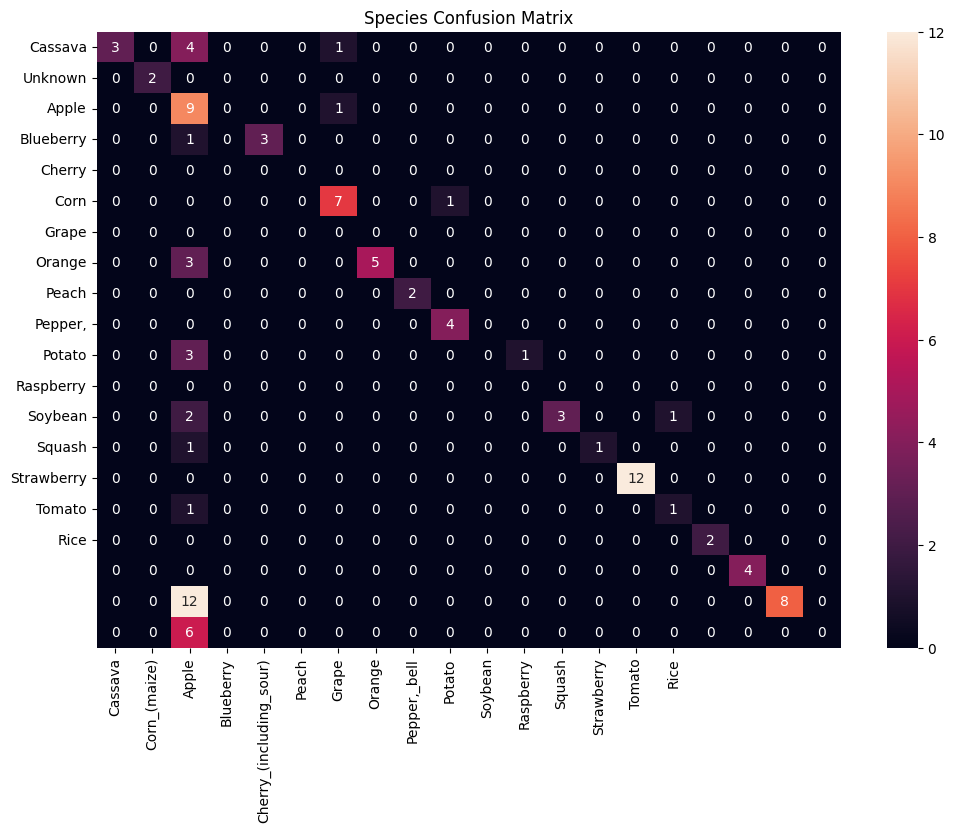

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(
    confusion_matrix(df["gt_species"], df["pred_species"]),
    annot=True, fmt="d",
    xticklabels=df["pred_species"].unique(),
    yticklabels=df["gt_species"].unique()
)
plt.title("Species Confusion Matrix")
plt.show()


c:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)


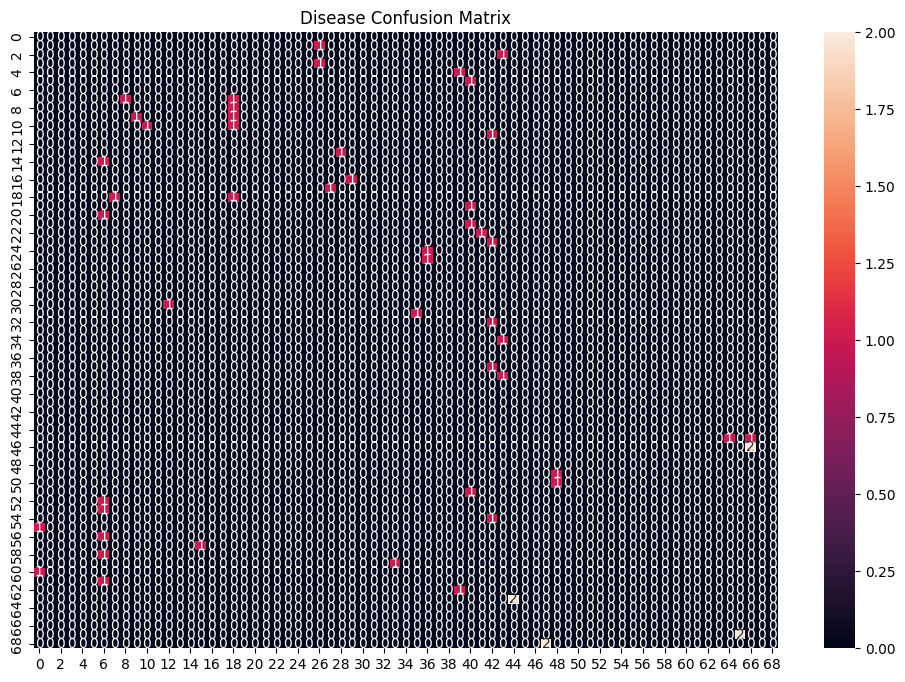

In [34]:
disease_df = df[df["gt_species"] == df["pred_species"]]

plt.figure(figsize=(12,8))
sns.heatmap(
    confusion_matrix(disease_df["gt_disease"], disease_df["pred_disease"]),
    annot=True, fmt="d"
)
plt.title("Disease Confusion Matrix")
plt.show()


In [35]:
print("PV classes:", pv_classes)
print("Cassava classes:", cassava_classes)
print("Rice classes:", rice_classes)


PV classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato